### Part3:  HW_target_customer

__Mathmatical View of the Problem__ 



A *two-for-one* sale, for example, a self-converted customer will spend 2 dollars for 2 gems, however, with promotions, the customer can buy 2 gems with 1 dollar. 
Assuming we have N$_{self convert}$ customers, the rest customers, might be converted by promotion sales N$_{target}$ by conversion rate p. 

- __Without promotion__:
Revenue only comes from self-converted customers. y_np = N$_{self convert}$$\times$2

- __Ideal case with promotion__:
We can perfectly identidy all the self-converted customers, and provide promotion codes to all the other non self-converted customers.
y_ideal = N$_{self convert}$$\times$2 + (N$_{total}$-N$_{self convert}$)$\times$1$\times$p 

- __Real case__:
We select our target customers N$_{target}$ and we might wrongly provide promotion code to self-converted customers (false negative). Assuming self-converted customers will definitely buy the product.
y_real = (N$_{self convert}$-FN)$\times$2 + FN$\times$1 + (N$_{target}$-FN)$\times$1$\times$p. 
The incremental revenue compared with no promotion (N$_{target}$-FN)$\times$1$\times$p-FN.   
Assuming p is a fixed small value, and alpha is the rate FN/N$_{target}$,
__y = [p-alpha$\times$(p+1)]$\times$N$_{target}$__


__Question #3__. 
Build a model in R or Python to help us identify users who are likely to convert on their own. This part can be done independently -- it’s not necessary to combine the output of this model with your other analyses. Please assume, however, that we would eventually do this.

Models used:
1. Logistic Regression
2. KNN
3. Random Forest

I choose these three models because 1) suitable for classification problem 2) these models can return probability predictions and therefore the threshold can be modified. The soft label is important here. 3) fewer parameters to tune.  

Metrics: 
False Negative/(False Negative + True Negative), Recall 

In [1]:
import pandas as pd
import numpy as np
from pylab import *
%matplotlib inline
import re
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from collections import Counter
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime,date

In [2]:
import hw
from hw import *

In [3]:
df = pd.read_csv('df_break.csv') # only the data before the first purchase 

In [4]:
from sklearn.preprocessing import LabelEncoder
lb = LabelEncoder()
df['country'] = lb.fit_transform(df['country'].astype(str))
df['lang'] = lb.fit_transform(df['lang'].astype(str))
df['hw_ver'] = lb.fit_transform(df['hw_ver'].astype(str))

In [5]:
(df.columns)

Index(['udid', 'install_date', 'lang', 'country', 'hw_ver', 'os_ver',
       'iaps_date', 'prod_name', 'prod_type', 'rev', 'amount',
       'delta_days_sess', 'delta_days_spend', 'total_story', 'rev_sum',
       'amount_sum', 'total_session', 'total_spend', 'amount_max',
       'session_date_dic', 'spend_date_dic', 'active_session_days',
       'active_spend_days', 'avg_session_per_day', 'avg_amount_per_day',
       'avg_session_duration', 'avg_spend_duration', 'retention_1',
       'retention_3', 'retention_7', 'retention_30', 'weekend', 'payer'],
      dtype='object')

### Outliers & Missing Data 

In [6]:
select_features = ['lang','country', 'hw_ver','os_ver','active_session_days', \
                   'amount_sum','amount_max','active_spend_days', \
                   'avg_session_per_day','total_story', \
                  'total_session', 'total_spend','weekend','payer','avg_amount_per_day',\
                   'avg_session_duration','avg_spend_duration','retention_1',\
                   'retention_3','retention_7','retention_30']

df = df[select_features]

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22576 entries, 0 to 22575
Data columns (total 21 columns):
lang                    22576 non-null int64
country                 22576 non-null int64
hw_ver                  22576 non-null int64
os_ver                  22576 non-null int64
active_session_days     22544 non-null float64
amount_sum              18017 non-null float64
amount_max              18017 non-null float64
active_spend_days       18017 non-null float64
avg_session_per_day     22544 non-null float64
total_story             18017 non-null float64
total_session           22544 non-null float64
total_spend             18017 non-null float64
weekend                 22576 non-null int64
payer                   22576 non-null int64
avg_amount_per_day      17997 non-null float64
avg_session_duration    17277 non-null float64
avg_spend_duration      7592 non-null float64
retention_1             22544 non-null float64
retention_3             22544 non-null float64
retention_7

### Remove Outliers & Fill in the Missing Data 

In [8]:
for col in ['amount_sum','avg_amount_per_day','total_session','amount_max','avg_session_per_day']: 
    df[col]=df[col].mask(df[col]<df[col].quantile(0.05)) 
    df[col]=df[col].mask(df[col]>df[col].quantile(0.95))

In [9]:
for col in ['amount_sum','avg_amount_per_day','total_session','amount_max','avg_session_per_day']:
    df[col] = df[col].fillna(median(df[df[col].notnull()][col]))

In [10]:
df = df.fillna(0)

In [11]:
df_p1 = df[df['payer']==0]
df_p2 = df[df['payer']==1]
df_p1 = df_p1.dropna() # if payer == 0, just drop the rows with NaNs because the dataset is imbalanced. 
len(df_p1)

21049

In [12]:
dt_new = pd.concat([df_p1,df_p2]).reset_index(drop=True)

In [13]:
dt_new.head(2)

,lang,country,hw_ver,os_ver,active_session_days,amount_sum,amount_max,active_spend_days,avg_session_per_day,total_story,...,total_spend,weekend,payer,avg_amount_per_day,avg_session_duration,avg_spend_duration,retention_1,retention_3,retention_7,retention_30
0,9,11,29,84,1.0,-22.0,22.0,1.0,1.0,1.0,...,1.0,0,0,-22.0,0.000000,0.00000,0.0,0.0,0.0,0.0
1,7,33,37,921,1.0,-44.0,22.0,1.0,3.0,3.0,...,5.0,0,0,-44.0,0.023964,0.00816,0.0,0.0,0.0,0.0


In [14]:
def DensityPlot(col,ax):
    sns.kdeplot(dt_new[dt_new['payer'] == 1][col], color='r', shade = True, label = 'payer',ax=ax)
    sns.kdeplot(dt_new[dt_new['payer'] == 0][col], color='b', shade = True, label = 'non-payer',ax=ax)
    ax.set_xlabel(col)

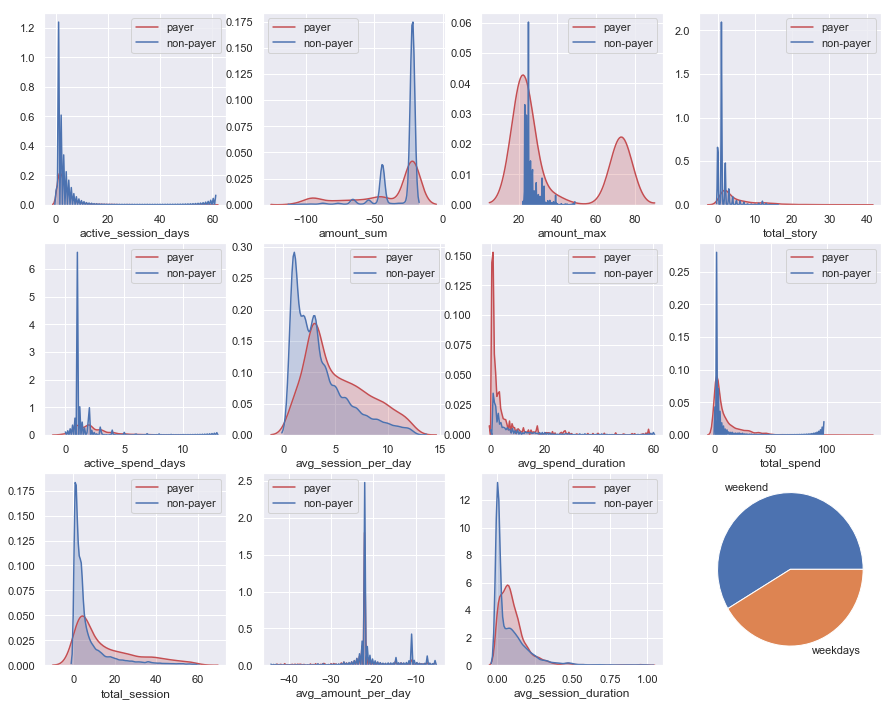

In [15]:
f, ax = plt.subplots(3, 4, figsize=(15, 12)) 
DensityPlot('active_session_days',ax=ax[0,0])
DensityPlot('amount_sum',ax=ax[0,1])
DensityPlot('amount_max',ax=ax[0,2])
DensityPlot('active_spend_days',ax=ax[1,0])
DensityPlot('avg_session_per_day',ax=ax[1,1])
DensityPlot('avg_spend_duration',ax=ax[1,2])
DensityPlot('total_story',ax=ax[0,3])
DensityPlot('total_spend',ax=ax[1,3])
DensityPlot('total_session',ax=ax[2,0])
DensityPlot('avg_amount_per_day',ax=ax[2,1])
DensityPlot('avg_session_duration',ax=ax[2,2])

sums = dt_new.groupby('weekend')['payer'].sum()
ax=ax[2,3].pie(sums, labels=['weekend','weekdays'])


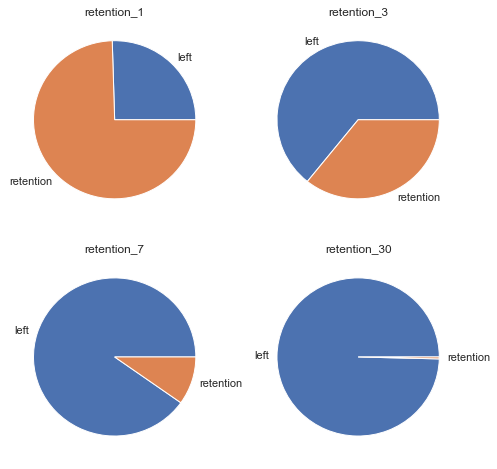

In [16]:
from matplotlib.pyplot import pie, axis, show
f, ax = plt.subplots(2, 2, figsize=(8, 8)) 
def plot_pie(col,ax):
    sums = dt_new.groupby(col)['payer'].sum()
    ax.pie(sums, labels=['left','retention'])
    ax.set_title(col)
    
plot_pie('retention_1',ax[0,0])
plot_pie('retention_3',ax[0,1])
plot_pie('retention_7',ax[1,0])
plot_pie('retention_30',ax[1,1])

### Models

Data: 
1. Downsample the class 0 data.
2. Scale the data (it is fine, no extreme values after removing the outliers). 

Models: 

1. Logistic Regression
2. KNN 
3. Random Forest 

__Evaluation Metrics__: 
1. Based on the mathematical discussion, if we sent the promotion to all the customers with predicted value 0 from the model, the revenue depends on alpha, which __False Negative / (False Negative + True Negative)__.   
2. Recall (True Positive/(True Positive+False Negative). 

In [17]:
df_p1 = dt_new[dt_new['payer']==0].sample(frac=0.3) # downsample 
df_p2 = dt_new[dt_new['payer']==1]
dt_m = pd.concat([df_p1,df_p2]).reset_index(drop=True)
dt_m.groupby('payer').count()['lang']

payer
0    6315
1    1527
Name: lang, dtype: int64

In [41]:
X_all = dt_new.drop(columns=['payer'])
y_all = dt_new['payer']

X=dt_m.drop(columns=['payer'])
y=dt_m['payer']

In [20]:
#plt.subplots(figsize=(10, 10))
#sns.heatmap(X.corr(),annot=True)

In [21]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

In [22]:
def alpha(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true,y_pred).ravel()
    error= fn/(fn+tn)
    return error
def print_model_results(model,name,cv,y,X):
    result = cross_val_score(model, X, y, cv=cv,scoring=myscore)
    print('Cross Validation '+name,' ',np.mean(-result))
    return np.mean(-result)

def print_result(model, threshold, X,y):
    pred_prob=model.predict_proba(X)[:,1]
    pred = np.where(pred_prob >0.1,1,0)
    #prediction = lr.predict(X_val)
    print('AUC score',roc_auc_score(y,pred_prob))
    print(confusion_matrix(y,pred))
    print('Alpha',alpha(y, pred))
    print('Recall',recall_score(y,pred))

In [23]:
myscore = make_scorer(alpha, greater_is_better=False)
kfold = KFold(n_splits=10, shuffle=True, random_state=0)

1. Logistic Regression 

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score,roc_curve,recall_score
from sklearn.metrics import confusion_matrix, classification_report

In [25]:
lr=LogisticRegression(C=2)
lr.fit(X_train,y_train)

LogisticRegression(C=2, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [26]:
cv_lr = print_model_results(lr,'Logistic Regression',kfold,y_train,X_train)

Cross Validation Logistic Regression   0.10112418848993392


In [27]:
print_result(lr, 0.1, X_test,y_test)

AUC score 0.8757050392972723
[[853 407]
 [ 50 259]]
Alpha 0.05537098560354374
Recall 0.8381877022653722


In [28]:
#plot_ROC(lr, X_val,y_val)
#coefs = np.abs(lr.coef_[0])
#indices = np.argsort(coefs)[::-1]

#plt.figure()
#plt.title("Feature importances (Logistic Regression)")
#plt.bar(range(10), coefs[indices[:10]],
#       color="r", align="center")
#plt.xticks(range(10), X_train.columns[indices[:10]], rotation=45, ha='right')
#plt.subplots_adjust(bottom=0.3)

In [29]:
print_result(lr, 0.1, X_all,y_all)

AUC score 0.8695816973418091
[[14011  7038]
 [  236  1291]]
Alpha 0.016564890854214923
Recall 0.8454485920104781


2. KNN 

In [30]:
from sklearn.neighbors import KNeighborsClassifier  
knn = KNeighborsClassifier(n_neighbors=7,metric='cityblock')  
knn.fit(X_train, y_train) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='cityblock',
           metric_params=None, n_jobs=1, n_neighbors=7, p=2,
           weights='uniform')

In [31]:
cv_knn = print_model_results(knn,'KNN',kfold,y_train,X_train)

Cross Validation KNN   0.10049802656743474


In [32]:
# validation 
print_result(knn, 0.1, X_test,y_test)

AUC score 0.8496481224636563
[[814 446]
 [ 50 259]]
Alpha 0.05787037037037037
Recall 0.8381877022653722


In [33]:
# all the data 
print_result(knn, 0.1, X_all,y_all)

AUC score 0.9191603102288255
[[13567  7482]
 [   55  1472]]
Alpha 0.004037586257524593
Recall 0.9639816633922724


3. Random Forest

In [34]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
param_dist = {"max_features": randint(1, 15),
              "min_samples_split":randint(2, 10),
              "min_samples_leaf":randint(1, 10),
              "criterion": ["gini", "entropy"]}
forest = RandomForestClassifier()
forest_cv = RandomizedSearchCV(estimator = forest, param_distributions = param_dist, \
            n_iter = 50, cv = 10, random_state=42, n_jobs = -1,scoring = myscore).fit(X_train,y_train)

In [35]:
forest_cv.best_params_

{'criterion': 'gini',
 'max_features': 8,
 'min_samples_leaf': 3,
 'min_samples_split': 7}

In [36]:
rf = RandomForestClassifier(criterion='gini',max_features=8,min_samples_leaf=3,min_samples_split=7)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=8, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=7,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [37]:
cv_rf = print_model_results(rf,'RF',kfold,y_train,X_train)

Cross Validation RF   0.08295021550389889


In [38]:
# validation 
print_result(rf, 0.1, X_test,y_test)

AUC score 0.9099617301073611
[[890 370]
 [ 37 272]]
Alpha 0.039913700107874865
Recall 0.8802588996763754


In [39]:
# all the data 
print_result(rf, 0.1, X_all,y_all)

AUC score 0.963415858521777
[[14990  6059]
 [   53  1474]]
Alpha 0.003523233397593565
Recall 0.9652914210870989


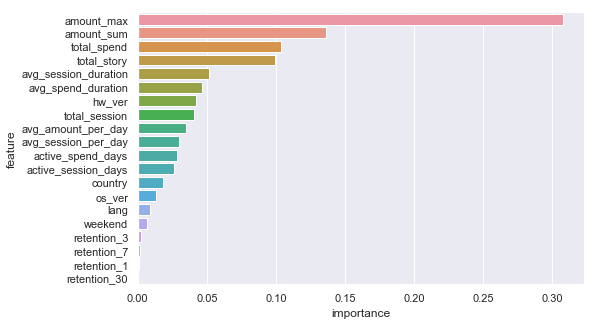

In [40]:
importances = list(rf.feature_importances_) ; feature_list = list(X.columns)
feature_importances = [(feature, importance) for feature, importance in \
                       zip(feature_list, importances)]
feature_importances = pd.DataFrame(feature_importances, columns=['feature','importance'])

feature_importances = feature_importances.sort_values(['importance'],\
                        ascending=False).reset_index(drop=True)

plt.subplots(figsize=(8, 5))
sns.barplot(y='feature', x='importance',data=feature_importances.iloc[:20])

In [54]:
print([cv_lr,cv_knn,cv_rf])

[0.1439193222464366, 0.1292148794885058, 0.10846719802403275]


__Summary_Model__
1. I built a classification model based on the 22576 customers game activity data (before the first 24hrs break) to seperate self-converted users and non self-converted users. To increase the revenue, we offer a two-for-one sale promotion to those non payers to stimulate consumption. 

2. The key to successfully increse revenue is to minimize the rate of true payers in the target promotion group (alpha). By lowering the probablity threshold for classification to 10%, which means we do not even offer promotion code to users that have 10% possibilty to be self-converted payers in the future. The rate from the best performed model (rf) can be around 0.37%. 

3. Important features indicated by the model, avg_spend_duration, avg_session_duration, amount_max. The frequency a user uses the app, the generosity of a user ... 

4. The promotion conversion rate p is unknown, if p is smaller than 0.37%, the revenue will decrease and the model needs to be refined. 


